In [89]:
import os
from typing import List, Dict, Tuple

import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import linear_model, svm, metrics, model_selection
import xgboost as xgb

from beat2d import settings

In [2]:
DATASET_PATH = "../data/oneshots/"
CLASSES = ["kick", "snare"]
LABELS = {"kick": 0, "snare": 1}

In [3]:
def load_dataset(dataset_path: str, classes: List[str]) -> Tuple[List[np.ndarray], List[str]]:
    data: List[np.ndarray] = []
    labels: List[str] = []
    
    for cls in classes:
        class_dir = os.path.join(DATASET_PATH, cls)
        class_dir = os.path.abspath(class_dir)
        
        if not os.path.isdir(class_dir):
            raise ValueError(f"No folder {cls} in {dataset_path}")
        
        for fname in os.listdir(class_dir):
            sample, sample_rate = librosa.core.load(os.path.join(class_dir, fname), settings.SAMPLE_RATE)
            data.append(sample)
            labels.append(LABELS[cls])
    
    return data, labels

In [4]:
data, labels = load_dataset(DATASET_PATH, CLASSES)

In [5]:
# Find the min, max, average length of the mfcc
min_ = float('inf')
max_ = -1
max_d = None
total = 0
lengths = []

for d in data:
    mfcc_d = librosa.feature.mfcc(d, sr=settings.SAMPLE_RATE, n_mfcc=40)
    
    length = mfcc_d.shape[1]
    lengths.append(length)
    
    total += length
    
    if length < min_:
        min_ = length
    
    if length > max_:
        max_ = length
    
avg = total / len(data)

print(min_, max_, avg)

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]


3 68 22.7027027027027


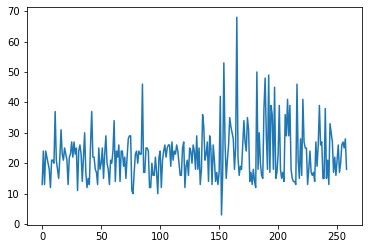

In [6]:
plt.plot(lengths)

Experimentally, 20 is probably a good place to pad to and cut to without losing data. This is probably even large for what I need, but we will try it for now.

In [7]:
def preprocess_data(data: List[np.ndarray], n_mfcc: int = 40, length: int = 20) -> List[np.ndarray]:
    preprocessed_data: List[np.ndarray] = []
    
    for idx, d in enumerate(data):
        preprocessed_d: np.ndarray = np.zeros((n_mfcc, length))
            
        mfcc_d: np.ndarray = librosa.feature.mfcc(d, sr=settings.SAMPLE_RATE, n_mfcc=n_mfcc, )
        preprocessed_d[:, :min(length, mfcc_d.shape[1])] = mfcc_d[:, :min(length, mfcc_d.shape[1])]
        
        preprocessed_data.append(preprocessed_d.flatten())
        
    return preprocessed_data

In [134]:
def predict_and_play(model, data, labels, idx):
    preds = model.predict(preprocess_data([data[idx]]))
    
    print(preds[0], labels[idx])
    return ipd.Audio(data[idx], rate=settings.SAMPLE_RATE)

def predict_and_play_xgb(model, data, labels, idx):
    preds = model.predict(np.array(preprocess_data([data[idx]])[0]))
    
    print(preds[0], labels[idx])
    return ipd.Audio(data[idx], rate=settings.SAMPLE_RATE)

In [135]:
predict_and_play_xgb(clf_xgb, X_test, y_test, 37)

ValueError: ('Expecting 2 dimensional numpy.ndarray, got: ', (800,))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

Training a Stochastic Gradient Descent Support Vector Machine classifier.

In [90]:
clf_SGDSVM = linear_model.SGDClassifier(loss="hinge", random_state=0)

In [93]:
model_selection.cross_val_score(clf_SGDSVM, preprocess_data(data), labels, cv=5, scoring="f1")

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]


array([0.51428571, 0.84210526, 0.82352941, 0.92      , 0.81355932])

In [48]:
clf_SGDSVM.fit(preprocess_data(X_train), y_train)

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]


SGDClassifier()

In [55]:
clf_SGDSVM.score(preprocess_data(X_test), y_test)

0.8461538461538461

In [81]:
predict_and_play(clf_SGDSVM, X_test, y_test, 36)

0 0


Training a Stochastic Gradient Descent Logistic Regression classifier.

In [94]:
clf_SGDLGR = linear_model.SGDClassifier(loss="log", random_state=0)

In [95]:
model_selection.cross_val_score(clf_SGDLGR, preprocess_data(data), labels, cv=5, scoring="f1")

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]


array([0.07407407, 0.45714286, 0.82539683, 0.8       , 0.8627451 ])

In [39]:
clf_SGDLGR.fit(X_train, y_train)

SGDClassifier(loss='log')

In [40]:
clf_SGDLGR.score(X_test, y_test)

0.7884615384615384

In [41]:
clf_SGDLGR.predict(X_test)

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1])

In [85]:
predict_and_play(clf_SGDLGR, X_test, y_test, 33)

0 0


Training a Support Vector classifier.

In [96]:
clf_SVC = svm.SVC(random_state=0)

In [97]:
model_selection.cross_val_score(clf_SVC, preprocess_data(data), labels, cv=5, scoring="f1")

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]


array([0.80701754, 0.8627451 , 0.7755102 , 0.83636364, 0.72      ])

In [117]:
clf_SVC.fit(preprocess_data(X_train), y_train)

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]


SVC(random_state=0)

In [115]:
clf_SVC.score(X_test, y_test)

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
clf_SVC.predict(X_test)

In [124]:
predict_and_play(clf_SVC, X_test, y_test, 37)

0 1


Training a Boosted Tree classifier.

In [25]:
dtrain = xgb.DMatrix(np.array(X_train), label=y_train)
dtest = xgb.DMatrix(np.array(X_test), label=y_test)

In [26]:
clf_xgb = xgb.XGBClassifier(objective="reg:logistic", learning_rate=0.1, label_encoder=False)

In [99]:
model_selection.cross_val_score(clf_xgb, np.array(preprocess_data(data)), labels, cv=5, scoring="f1")

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:28:26] WARNING: ../src/learner.cc:541: 
Parameters: { label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:28:26] WARNING: ../src/learner.cc:541: 
Parameters: { label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:28:26] WARNING: ../src/learner.cc:541: 
Parameters: { label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[

array([0.81481481, 0.88      , 0.81632653, 0.90566038, 0.88461538])

In [102]:
clf_xgb.fit(np.array(preprocess_data(X_train)), y_train)

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]


[19:28:53] WARNING: ../src/learner.cc:541: 
Parameters: { label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              label_encoder=False, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [125]:
predict_and_play_xgb(clf_xgb, data, labels, 37)

ParameterError: Audio data must be of type numpy.ndarray

In [104]:
preds = clf_xgb.predict(np.array(preprocess_data(X_test)))

In [105]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))

In [106]:
print("RMSE: %f" % (rmse))

RMSE: 0.196116


In [107]:
clf_xgb.save_model("xgb_model.model")

In [108]:
preds

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0])